In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import copy
from tqdm import tqdm
from pathlib import Path

from src.load_data import (
    read_graph_transport_networks_tntp,
    read_traffic_mat_transport_networks_tntp,
)

from src.models import BeckmannModel, TwostageModel
from src.algs import cyclic
from src.salim import SaddleOracle, combined_salim

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator


plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

# Load network data

In [3]:
networks_path = Path("./TransportationNetworks")

folder = "SiouxFalls"
net_name = "SiouxFalls_net"
traffic_mat_name = "SiouxFalls_trips"

net_file = networks_path / folder / f"{net_name}.tntp"
traffic_mat_file = networks_path / folder / f"{traffic_mat_name}.tntp"
graph, metadata = read_graph_transport_networks_tntp(net_file)
correspondences = read_traffic_mat_transport_networks_tntp(traffic_mat_file, metadata)
n = graph.number_of_nodes()

print(f"{graph.number_of_edges()=}, {graph.number_of_nodes()=}")

metadata["can_pass_through_zones"]=True
graph.number_of_edges()=76, graph.number_of_nodes()=24


In [4]:
traffic_mat = correspondences.traffic_mat.copy()
departures, arrivals = traffic_mat.sum(axis=1), traffic_mat.sum(axis=0)
l, w = departures, arrivals

# Create instances of models/oracles

In [5]:
beckmann_model = BeckmannModel(graph, copy.deepcopy(correspondences))
twostage_beckmann_model = TwostageModel(beckmann_model, departures=departures, arrivals=arrivals, gamma=0.1)
saddle_oracle = SaddleOracle(twostage_beckmann_model.traffic_model, twostage_beckmann_model.gamma, l, w)

/home/demyan/reps/mmo_tm/src/salim.py:23: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.incidence_mat = nx.incidence_matrix(traffic_model.nx_graph, oriented=True).todense()


# Dict with the parameters of the experiment and fields to save experiment data

In [6]:
# for Sioux-Falls
comment = "3FW in sequntial"
ta_epss = list(10.0 ** np.arange(2, -1, -1))
experiment = {
    "meta": {
        "network": folder,
        "description": comment,
    },
    "cyclic_big_iters": 15,
    "cyclic_ta_iters": 10_000,
    "ta_epss": ta_epss,
    "salim_kwargs": dict(mu=1e-4, L=1, lam2=l.size, lam1=3 * l.size),
    "salim_iters": 2000,
    "salim_exact_iters": 5000,
    "data": {
        "dgapss": None,
        "timess": None,
        "distss": None,
        "salim_exact_cons": None,
        "salim_exact_opt": None,
        "salim_times": None,
        "salim_dists": None,
    },
}
data = experiment["data"]

# Obtain almost exact solution

In [7]:
output = combined_salim(saddle_oracle, **experiment["salim_kwargs"],
                        iters=experiment["salim_exact_iters"],
                        plot_convergence=False)
corrs_best, flows_best, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output
flows_e_best = flows_best.sum(axis=1)

data["salim_exact_times"], data["salim_exact_cons"], data["salim_exact_opt"] = times_s, pri_res, opt

100%|██████████| 5000/5000 [00:01<00:00, 3625.37it/s]

Lmax= 3.324583346408148
mumin= 0.0006031075674859811
2.1140046882718803e-07 4.130457235826189e-06 1.3037144165750265e-08


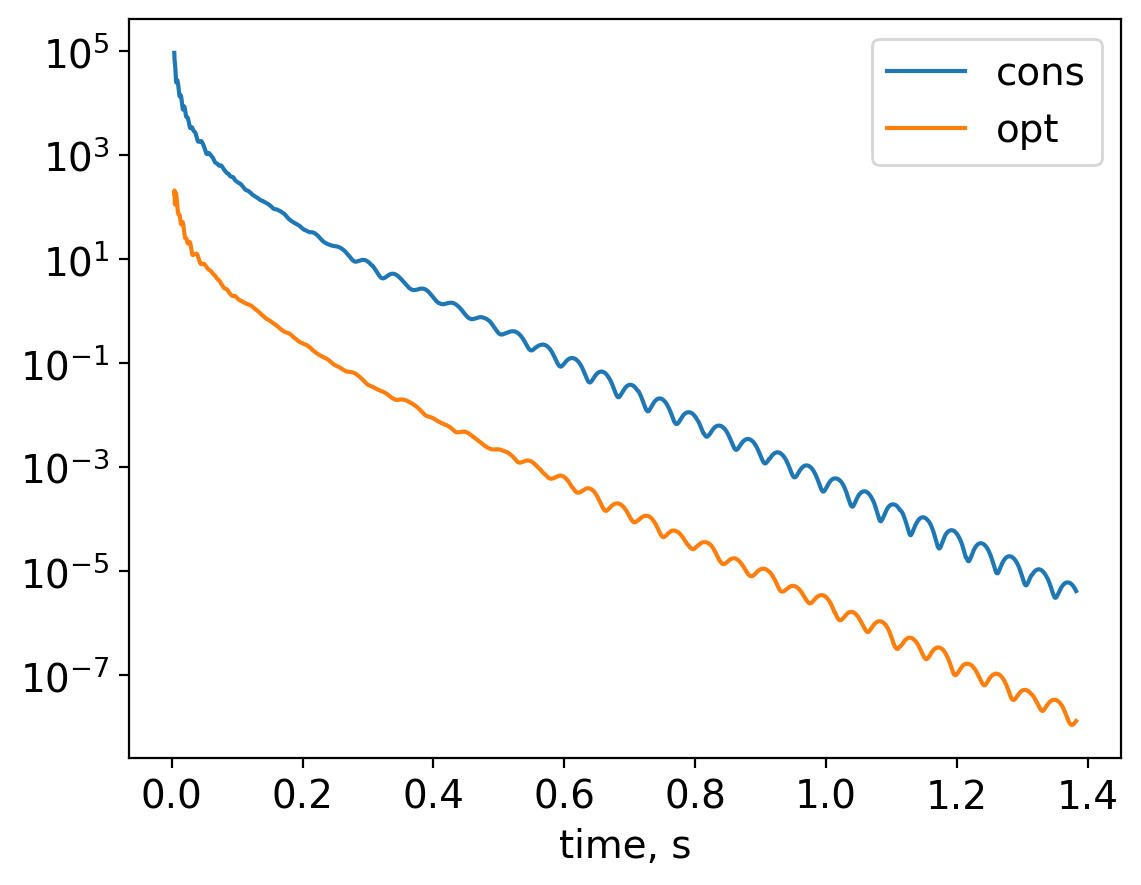

In [8]:
plt.plot(data["salim_exact_times"], data["salim_exact_cons"], label="cons")
plt.plot(data["salim_exact_times"], data["salim_exact_opt"], label="opt")
plt.legend()
plt.xlabel("time, s")
plt.yscale("log")

# Run OFAC

In [9]:
salim_kwargs = dict(mu=1e-8, L=100,lam2=1e-4 * l.size, lam1=3.5*l.size)
salim_kwargs = experiment["salim_kwargs"]
output = combined_salim(saddle_oracle, **salim_kwargs, iters=experiment["salim_iters"],
               solution_corrs=corrs_best,
               solution_flows=flows_e_best,
               )

corrs_salim, flows_salim, yK_s, yAB_s, dists_s, times_s, pri_res, opt = output

data["salim_times"], data["salim_dists"] = times_s, dists_s

100%|██████████| 2000/2000 [00:00<00:00, 3614.23it/s]

Lmax= 3.324583346408148
mumin= 0.0006237944271523264
0.01484088896642664 0.1921263912556951 0.0011478223771000438


(<matplotlib.legend.Legend at 0x7fb544fc30d0>, None)

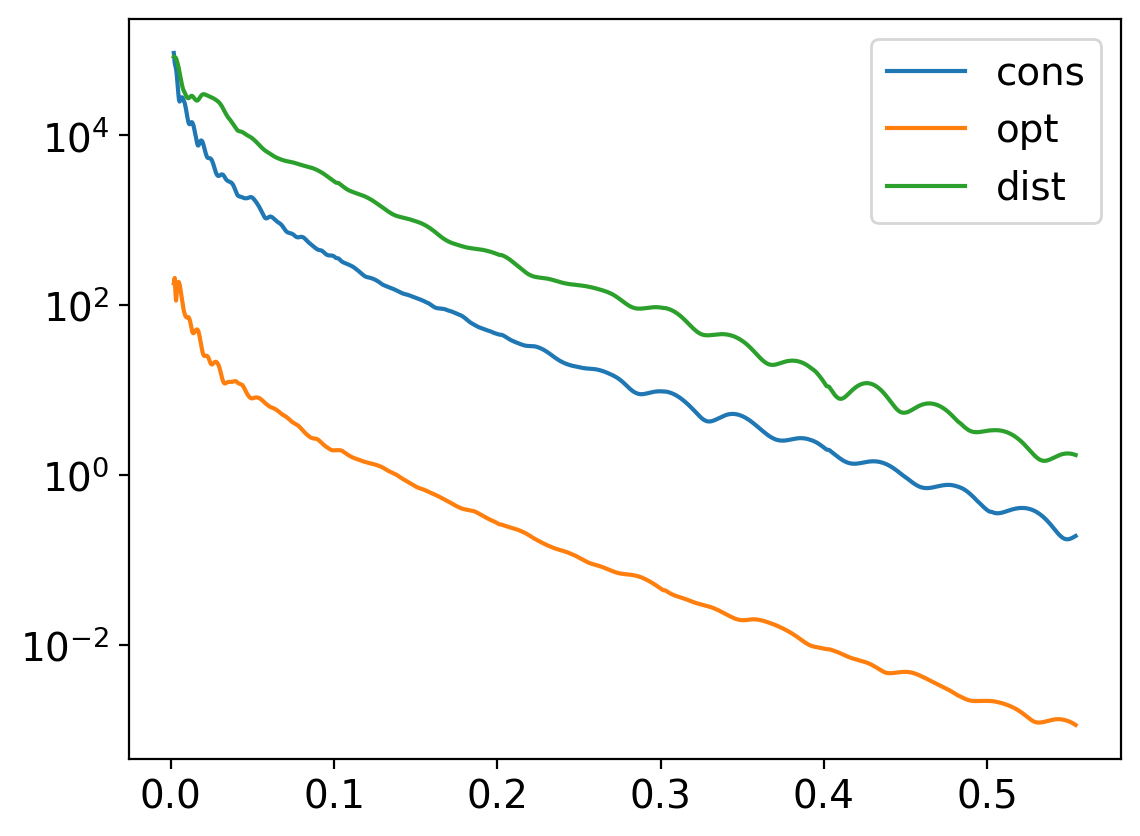

In [10]:
plt.plot(times_s, pri_res, label="cons")
plt.plot(times_s, opt, label="opt")
plt.plot(times_s, dists_s, label="dist")
plt.legend(), plt.yscale("log")


# Run sequntial procedure for different values of FW gap

In [11]:
dgapss = []
timess = []
distss = []

for ta_eps in experiment["ta_epss"]:
    output = cyclic(model=twostage_beckmann_model,
                    traffic_assigment_eps_abs=ta_eps, 
                    traffic_assigment_max_iter=experiment["cyclic_ta_iters"], 
                    max_iter=experiment["cyclic_big_iters"], 
                    stop_by_crit=False,
                    solution_flows=flows_e_best,
                    solution_corrs=corrs_best,
                   )
    times_e_cyclic, flows_e_cyclic, d_ij_cyclic, logs, optimal = output
    dgap_cyclic, cons_log_cyclic, time_log_cyclic, dist_flows_log, dist_corrs_log = logs
    
    dgapss.append(dgap_cyclic)    
    timess.append(list(time_log_cyclic))
    distss.append(list((np.array(dist_flows_log) ** 2 + np.array(dist_corrs_log) ** 2) ** 0.5))
    
data["dgapss"] = dgapss
data["timess"] = timess 
data["distss"] = distss 

100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


# Save results

In [12]:
import json

with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "w") as fp:
    json.dump(experiment, fp)

# Plot results

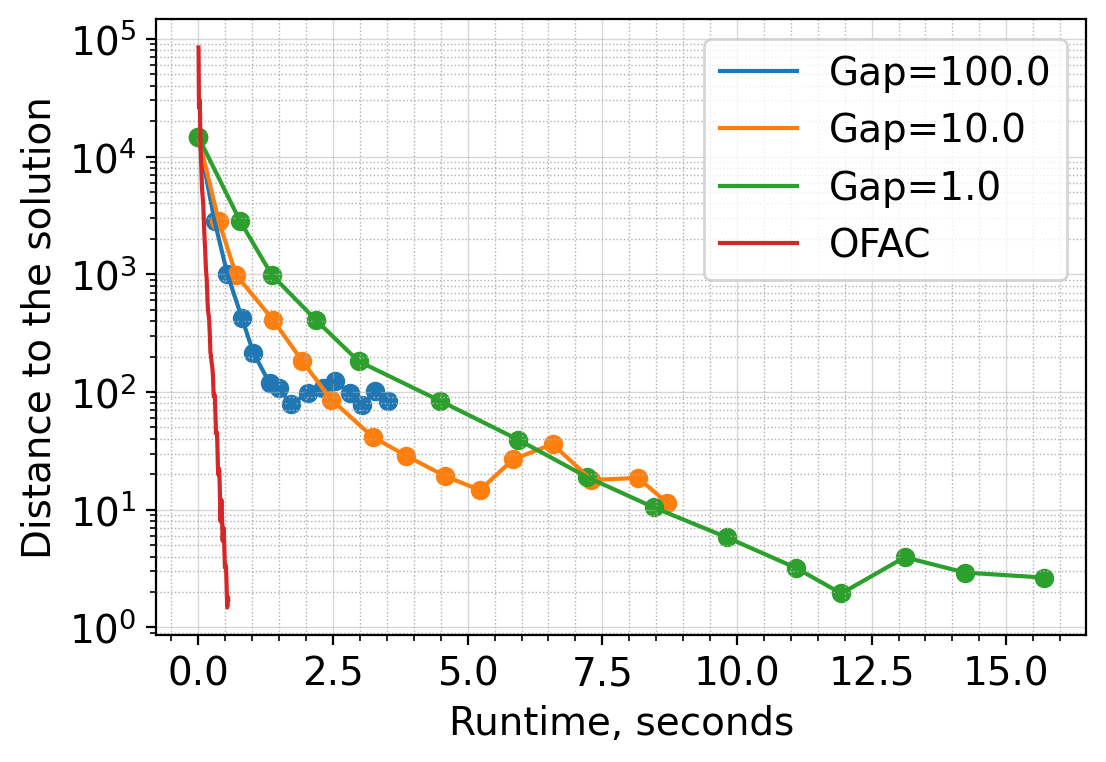

In [13]:
with open(f"experiments_data/{folder}_salim_vs_cyclic.json", "r") as fp:
    experiment = json.load(fp)
data = experiment["data"]
    
plt.figure(figsize=(6,4))

ta_epss = experiment["ta_epss"]
for i in range(len(ta_epss)):
    times, dists = data["timess"][i], data["distss"][i] 
    plt.plot(times, dists, label=f"Gap={ta_epss[i]}")
    plt.scatter(times, dists)

plt.plot(data["salim_times"], data["salim_dists"], label="OFAC")

plt.minorticks_on()
plt.yscale("log")

plt.ylabel("Distance to the solution")
plt.xlabel("Runtime, seconds")

minor_locator = LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=12)
plt.gca().yaxis.set_minor_locator(minor_locator)

plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=1) 

plt.legend()

plt.savefig(f"experiments_data/{folder}.pdf", bbox_inches="tight")